In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.utils import resample
import joblib
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Chargement des données
df = pd.read_csv('creditcarddata.csv')
df.head()

,Gender,Age,HouseTypeID,ContactAvaliabilityID,HomeCountry,AccountNo,CardExpiryDate,TransactionAmount,TransactionCountry,LargePurchase,ProductID,CIF,TransactionCurrencyCode,PotentialFraud
0,0,56,1,0,1,1109976,1811,0.0062,1,0,3,11020290,1,0
1,0,56,1,0,1,1109976,1811,0.0062,1,0,3,11020290,1,0
2,0,56,1,0,1,1109976,1811,0.0062,1,0,3,11020290,1,0
3,0,56,1,0,1,1109976,1811,0.0062,1,0,3,11020290,1,0
4,0,56,1,0,1,1109976,1811,1.0354,1,0,3,11020290,1,0


In [4]:
# Liste des modèles pour la classification binaire (détection de fraude)
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

Gender: Aucune valeur manquante
Age: Aucune valeur manquante
HouseTypeID: Aucune valeur manquante
ContactAvaliabilityID: Aucune valeur manquante
HomeCountry: Aucune valeur manquante
AccountNo: Aucune valeur manquante
CardExpiryDate: Aucune valeur manquante
TransactionAmount: Aucune valeur manquante
TransactionCountry: Aucune valeur manquante
LargePurchase: Aucune valeur manquante
ProductID: Aucune valeur manquante
CIF: Aucune valeur manquante
TransactionCurrencyCode: Aucune valeur manquante
PotentialFraud: Aucune valeur manquante
Aucune valeur manquante à traiter
933 doublons supprimés
Taille avant: 2266, Taille après: 1333
Distribution de la variable cible:
Classe 0 (Non fraude): 1185 (88.9%)
Classe 1 (Fraude): 148 (11.1%)
Ratio de déséquilibre: 8.0:1


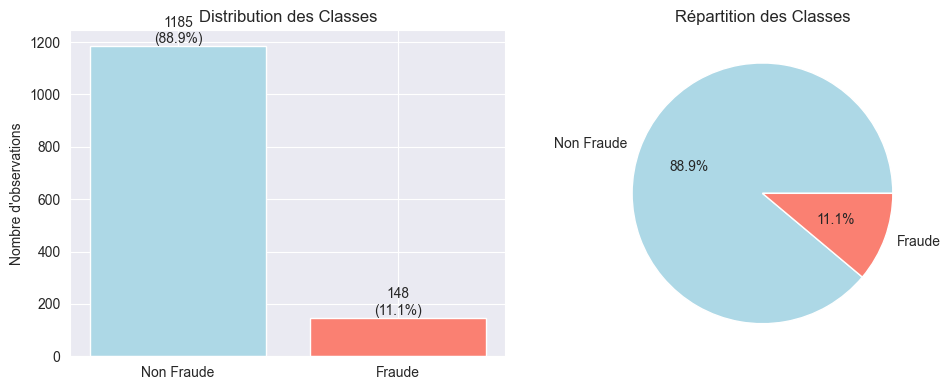

Application de l'oversampling
Après équilibrage:
Classe 0: 1185 observations
Classe 1: 1185 observations
Taille totale: 2370 observations


In [5]:
# Vérification des valeurs manquantes
missing_values = df.isnull().sum()
for col, missing in missing_values.items():
    if missing > 0:
        print(f"{col}: {missing} valeurs manquantes")
    else:
        print(f"{col}: Aucune valeur manquante")

# Traitement des valeurs manquantes
if missing_values.sum() > 0:
    # Remplissage par la médiane pour les variables numériques
    for col in df.select_dtypes(include=[np.number]).columns:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"{col}: Rempli avec la médiane ({median_val:.2f})")
else:
    print("Aucune valeur manquante à traiter")

#Vérification des doublons
duplicates = df.duplicated().sum()

if duplicates > 0:
    df_before = len(df)
    df = df.drop_duplicates()
    print(f"{duplicates} doublons supprimés")
    print(f"Taille avant: {df_before}, Taille après: {len(df)}")
else:
    print("Aucun doublon détecté")

#Analyse du déséquilibre des classes
class_dist = df['PotentialFraud'].value_counts()
print("Distribution de la variable cible:")
print(f"Classe 0 (Non fraude): {class_dist[0]} ({class_dist[0]/len(df)*100:.1f}%)")
print(f"Classe 1 (Fraude): {class_dist[1]} ({class_dist[1]/len(df)*100:.1f}%)")

des_ratio = class_dist[0] / class_dist[1]
print(f"Ratio de déséquilibre: {des_ratio:.1f}:1")

# Visualisation du déséquilibre
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
bars = plt.bar(['Non Fraude', 'Fraude'], class_dist.values, color=['lightblue', 'salmon'])
plt.title('Distribution des Classes')
plt.ylabel('Nombre d\'observations')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}\n({height/len(df)*100:.1f}%)',
             ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.pie(class_dist.values, labels=['Non Fraude', 'Fraude'], autopct='%1.1f%%',
        colors=['lightblue', 'salmon'])
plt.title('Répartition des Classes')

plt.tight_layout()
plt.show()

#Traitement du déséquilibre
print("Application de l'oversampling")

df_majority = df[df['PotentialFraud'] == 0]
df_minority = df[df['PotentialFraud'] == 1]

# Oversampling de la classe minoritaire
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Vérification après équilibrage
balanced_dist = df_balanced['PotentialFraud'].value_counts()
print("Après équilibrage:")
print(f"Classe 0: {balanced_dist[0]} observations")
print(f"Classe 1: {balanced_dist[1]} observations")
print(f"Taille totale: {len(df_balanced)} observations")


In [8]:
# Préparation des features et target
X = df_balanced.drop('PotentialFraud', axis=1)
y = df_balanced['PotentialFraud']

print("Préparation des variables:")
print(f"- Features (X): {X.shape}")
print(f"- Target (y): {y.shape}")

# Normalisation des données
print("\nNormalisation des données")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Division en train/test (70%/30%)
print("Division train/test (70%/30%)")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Résultats de la division:")
print(f"- X_train: {X_train.shape} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"- X_test: {X_test.shape} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"- y_train: {y_train.shape}")
print(f"- y_test: {y_test.shape}")

# Vérification de la distribution dans les splits
print("\nDistribution des classes dans les splits:")
print(f"   - Train - Classe 0: {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"   - Train - Classe 1: {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"   - Test - Classe 0: {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"   - Test - Classe 1: {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")

Préparation des variables:
- Features (X): (2370, 13)
- Target (y): (2370,)

Normalisation des données
Division train/test (70%/30%)
Résultats de la division:
- X_train: (1659, 13) (70.0%)
- X_test: (711, 13) (30.0%)
- y_train: (1659,)
- y_test: (711,)

Distribution des classes dans les splits:
   - Train - Classe 0: 829 (50.0%)
   - Train - Classe 1: 830 (50.0%)
   - Test - Classe 0: 356 (50.1%)
   - Test - Classe 1: 355 (49.9%)


In [9]:
# Dictionnaire pour stocker les modèles entraînés
trained_models = {}
training_times = {}
predictions = {}
prediction_probas = {}

for name, model in models.items():
    print(f" Entraînement du modèle: {name}")

    # Mesure du temps d'entraînement
    import time
    start_time = time.time()

    # Entraînement du modèle
    model.fit(X_train, y_train)

    # Calcul du temps d'entraînement
    training_time = time.time() - start_time
    training_times[name] = training_time

    # Prédictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Stockage des résultats
    trained_models[name] = model
    predictions[name] = y_pred
    prediction_probas[name] = y_proba

    # Score d'entraînement
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f"Entraînement terminé en {training_time:.2f} secondes")
    print(f"Score entraînement: {train_score:.4f}")
    print(f"Score test: {test_score:.4f}")


print(f"{len(trained_models)} modèles entraînés avec succès")
print("\nTemps d'entraînement par modèle:")
for name, time_taken in training_times.items():
    print(f"- {name}: {time_taken:.2f} secondes")

 Entraînement du modèle: Logistic Regression
Entraînement terminé en 0.01 secondes
Score entraînement: 0.6926
Score test: 0.6807
 Entraînement du modèle: Random Forest
Entraînement terminé en 0.19 secondes
Score entraînement: 0.9825
Score test: 0.9325
 Entraînement du modèle: Gradient Boosting
Entraînement terminé en 0.19 secondes
Score entraînement: 0.8909
Score test: 0.8397
 Entraînement du modèle: SVM
Entraînement terminé en 0.36 secondes
Score entraînement: 0.7589
Score test: 0.7426
 Entraînement du modèle: K-Nearest Neighbors
Entraînement terminé en 0.00 secondes
Score entraînement: 0.8831
Score test: 0.8340
5 modèles entraînés avec succès

Temps d'entraînement par modèle:
- Logistic Regression: 0.01 secondes
- Random Forest: 0.19 secondes
- Gradient Boosting: 0.19 secondes
- SVM: 0.36 secondes
- K-Nearest Neighbors: 0.00 secondes


Génération des matrices de confusion

Logistic Regression:
- Vrais Négatifs (TN): 175 - Correctement identifiés comme non-fraude
- Faux Positifs (FP): 181 - Non-fraude classés comme fraude (Erreur Type I)
- Faux Négatifs (FN): 46 - Fraude non détectée (Erreur Type II - CRITIQUE)
- Vrais Positifs (TP): 309 - Fraude correctement détectée

Random Forest:
- Vrais Négatifs (TN): 308 - Correctement identifiés comme non-fraude
- Faux Positifs (FP): 48 - Non-fraude classés comme fraude (Erreur Type I)
- Faux Négatifs (FN): 0 - Fraude non détectée (Erreur Type II - CRITIQUE)
- Vrais Positifs (TP): 355 - Fraude correctement détectée

Gradient Boosting:
- Vrais Négatifs (TN): 264 - Correctement identifiés comme non-fraude
- Faux Positifs (FP): 92 - Non-fraude classés comme fraude (Erreur Type I)
- Faux Négatifs (FN): 22 - Fraude non détectée (Erreur Type II - CRITIQUE)
- Vrais Positifs (TP): 333 - Fraude correctement détectée

SVM:
- Vrais Négatifs (TN): 190 - Correctement identifiés comme non-fr

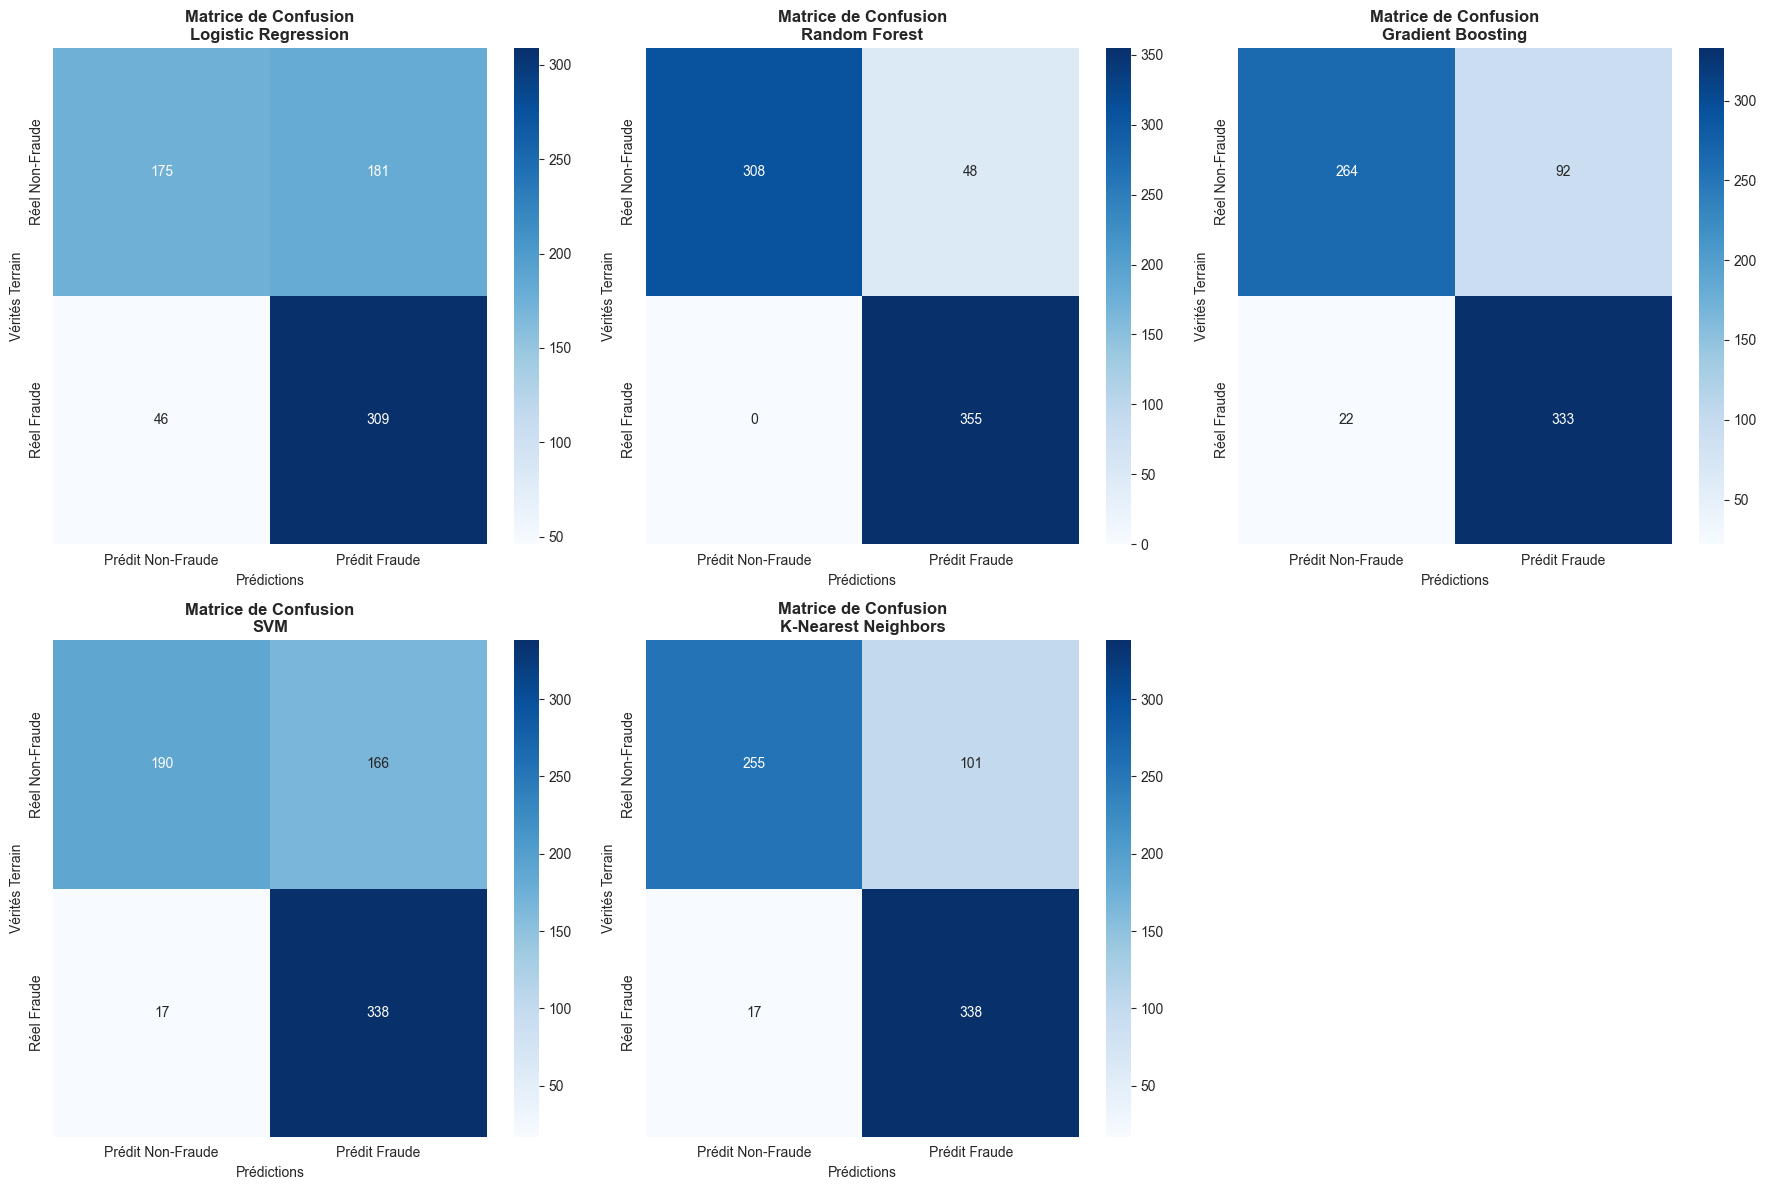


ANALYSE DES MATRICES DE CONFUSION:
• Faux Négatifs (FN): Transactions frauduleuses non détectées - RISQUE ÉLEVÉ
• Faux Positifs (FP): Fausses alertes - impacte l'expérience client
• Objectif: Minimiser les Faux Négatifs tout en contrôlant les Faux Positifs


In [10]:
# Fonction pour afficher une matrice de confusion détaillée
def plot_detailed_confusion_matrix(y_true, y_pred, model_name, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Prédit Non-Fraude', 'Prédit Fraude'],
                yticklabels=['Réel Non-Fraude', 'Réel Fraude'])
    ax.set_title(f'Matrice de Confusion\n{model_name}', fontweight='bold')
    ax.set_xlabel('Prédictions')
    ax.set_ylabel('Vérités Terrain')

# Création de la figure avec toutes les matrices de confusion
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

print("Génération des matrices de confusion")

for idx, (name, y_pred) in enumerate(predictions.items()):
    # Affichage de la matrice de confusion
    plot_detailed_confusion_matrix(y_test, y_pred, name, axes[idx])

    # Analyse détaillée de la matrice
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print(f"\n{name}:")
    print(f"- Vrais Négatifs (TN): {tn} - Correctement identifiés comme non-fraude")
    print(f"- Faux Positifs (FP): {fp} - Non-fraude classés comme fraude (Erreur Type I)")
    print(f"- Faux Négatifs (FN): {fn} - Fraude non détectée (Erreur Type II - CRITIQUE)")
    print(f"- Vrais Positifs (TP): {tp} - Fraude correctement détectée")

# Masquer le dernier subplot s'il n'est pas utilisé
for idx in range(len(predictions), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

print("\nANALYSE DES MATRICES DE CONFUSION:")
print("• Faux Négatifs (FN): Transactions frauduleuses non détectées - RISQUE ÉLEVÉ")
print("• Faux Positifs (FP): Fausses alertes - impacte l'expérience client")
print("• Objectif: Minimiser les Faux Négatifs tout en contrôlant les Faux Positifs")


Logistic Regression:
Accuracy: 0.6807
Precision: 0.6306
Recall: 0.8704
F1-Score: 0.7314
Specificity: 0.4916
Taux d'erreur: 0.3193

Random Forest:
Accuracy: 0.9325
Precision: 0.8809
Recall: 1.0000
F1-Score: 0.9367
Specificity: 0.8652
Taux d'erreur: 0.0675

Gradient Boosting:
Accuracy: 0.8397
Precision: 0.7835
Recall: 0.9380
F1-Score: 0.8538
Specificity: 0.7416
Taux d'erreur: 0.1603

SVM:
Accuracy: 0.7426
Precision: 0.6706
Recall: 0.9521
F1-Score: 0.7870
Specificity: 0.5337
Taux d'erreur: 0.2574

K-Nearest Neighbors:
Accuracy: 0.8340
Precision: 0.7699
Recall: 0.9521
F1-Score: 0.8514
Specificity: 0.7163
Taux d'erreur: 0.1660

TABLEAU COMPARATIF DES PERFORMANCES
                Modèle  Accuracy  Precision  Recall  F1-Score  Specificity  \
0  Logistic Regression    0.6807     0.6306  0.8704    0.7314       0.4916   
1        Random Forest    0.9325     0.8809  1.0000    0.9367       0.8652   
2    Gradient Boosting    0.8397     0.7835  0.9380    0.8538       0.7416   
3                  S

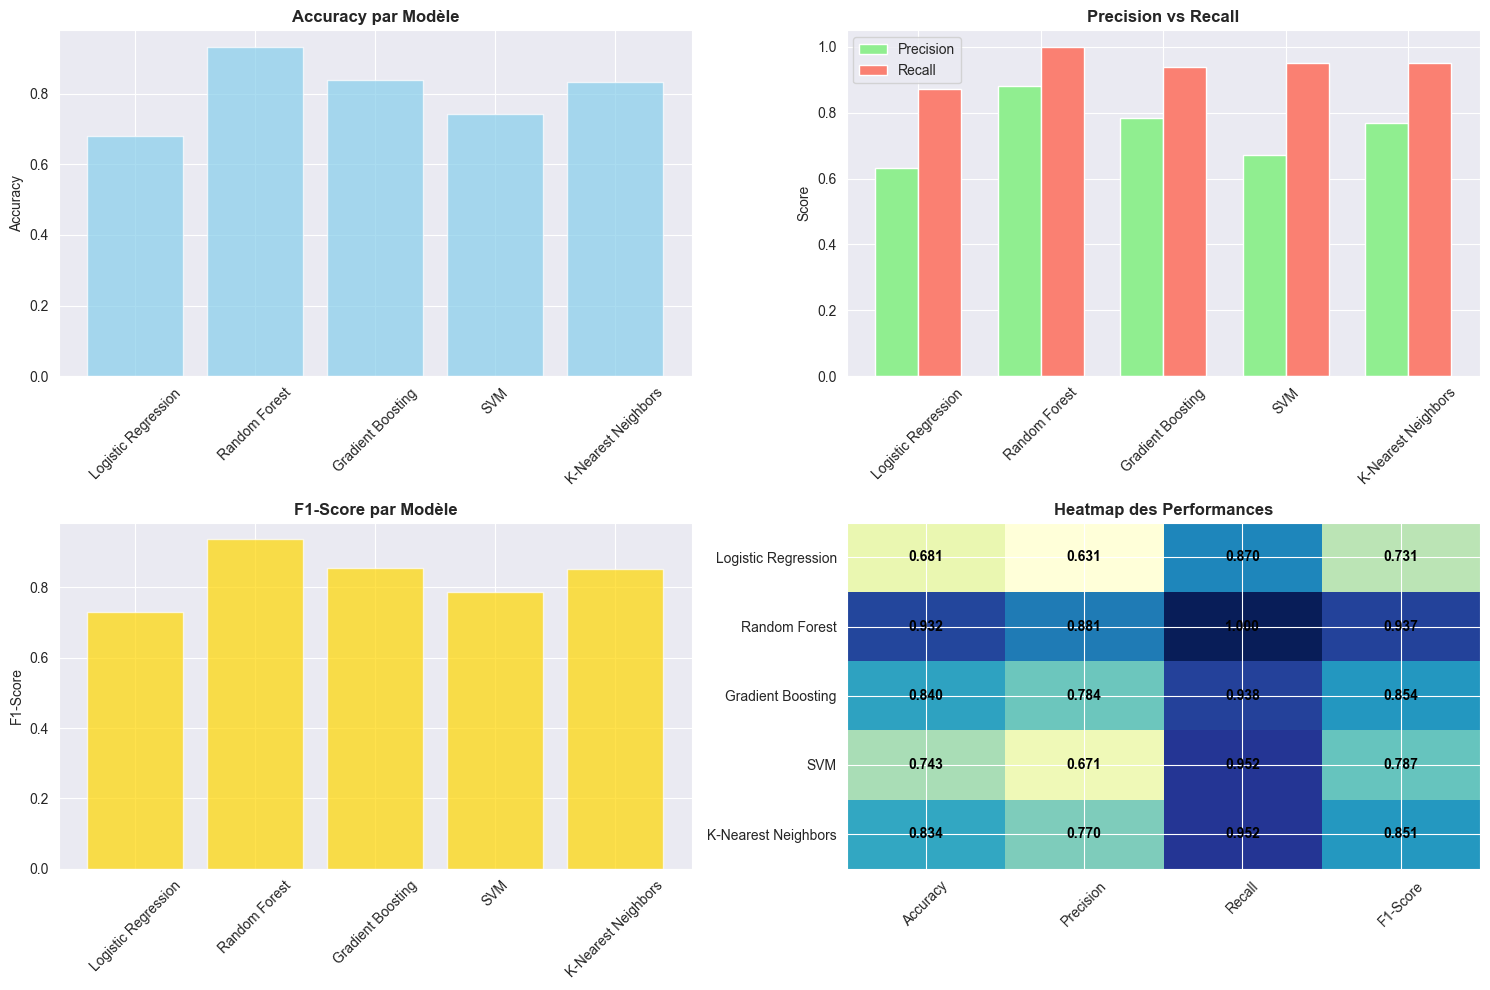

In [11]:
# Calcul des métriques pour chaque modèle
results = []
for name in trained_models.keys():
    y_pred = predictions[name]

    # Calcul des métriques de base
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Matrice de confusion pour métriques supplémentaires
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Taux d'erreur
    error_rate = (fp + fn) / (tp + tn + fp + fn)

    # Spécificité
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    results.append({
        'Modèle': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Specificity': specificity,
        'Error Rate': error_rate,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn
    })

    print(f"\n{name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Taux d'erreur: {error_rate:.4f}")

# Création du DataFrame des résultats
results_df = pd.DataFrame(results)

print("\n" + "=" * 50)
print("TABLEAU COMPARATIF DES PERFORMANCES")
print("=" * 50)
print(results_df.round(4))

# Visualisation comparative des métriques
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0,0].bar(results_df['Modèle'], results_df['Accuracy'], color='skyblue', alpha=0.7)
axes[0,0].set_title('Accuracy par Modèle', fontweight='bold')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].tick_params(axis='x', rotation=45)

# Precision et Recall
x = range(len(results_df))
width = 0.35
axes[0,1].bar([i - width/2 for i in x], results_df['Precision'], width, label='Precision', color='lightgreen')
axes[0,1].bar([i + width/2 for i in x], results_df['Recall'], width, label='Recall', color='salmon')
axes[0,1].set_title('Precision vs Recall', fontweight='bold')
axes[0,1].set_ylabel('Score')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(results_df['Modèle'], rotation=45)
axes[0,1].legend()

# F1-Score
axes[1,0].bar(results_df['Modèle'], results_df['F1-Score'], color='gold', alpha=0.7)
axes[1,0].set_title('F1-Score par Modèle', fontweight='bold')
axes[1,0].set_ylabel('F1-Score')
axes[1,0].tick_params(axis='x', rotation=45)

# Matrice de performance
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
performance_data = results_df[metrics_to_plot].values
im = axes[1,1].imshow(performance_data, cmap='YlGnBu', aspect='auto')
axes[1,1].set_xticks(range(len(metrics_to_plot)))
axes[1,1].set_xticklabels(metrics_to_plot, rotation=45)
axes[1,1].set_yticks(range(len(results_df)))
axes[1,1].set_yticklabels(results_df['Modèle'])
axes[1,1].set_title('Heatmap des Performances', fontweight='bold')

# Ajouter les valeurs dans la heatmap
for i in range(len(results_df)):
    for j in range(len(metrics_to_plot)):
        text = axes[1,1].text(j, i, f'{performance_data[i, j]:.3f}',
                           ha="center", va="center", color="black", fontweight='bold')

plt.tight_layout()
plt.show()


Classement par Accuracy:
1. Random Forest: 0.9325
2. Gradient Boosting: 0.8397
3. K-Nearest Neighbors: 0.8340
4. SVM: 0.7426
5. Logistic Regression: 0.6807

Classement par Recall (MÉTRIQUE CLÉ):
1. Random Forest: 1.0000
2. K-Nearest Neighbors: 0.9521
3. SVM: 0.9521
4. Gradient Boosting: 0.9380
5. Logistic Regression: 0.8704

Classement par F1-Score:
1. Random Forest: 0.9367
2. Gradient Boosting: 0.8538
3. K-Nearest Neighbors: 0.8514
4. SVM: 0.7870
5. Logistic Regression: 0.7314

ANALYSE DÉTAILLÉE DES PERFORMANCES

Logistic Regression:
• Capacité de détection (Recall): 87.0% des fraudes détectées
• Précision des alertes: 63.1% des alertes sont de vraies fraudes
• Exactitude globale: 68.1% de prédictions correctes
• Faux négatifs: 46 fraudes non détectées (RISQUE)
• Faux positifs: 181 fausses alertes

Random Forest:
• Capacité de détection (Recall): 100.0% des fraudes détectées
• Précision des alertes: 88.1% des alertes sont de vraies fraudes
• Exactitude globale: 93.2% de prédictions c

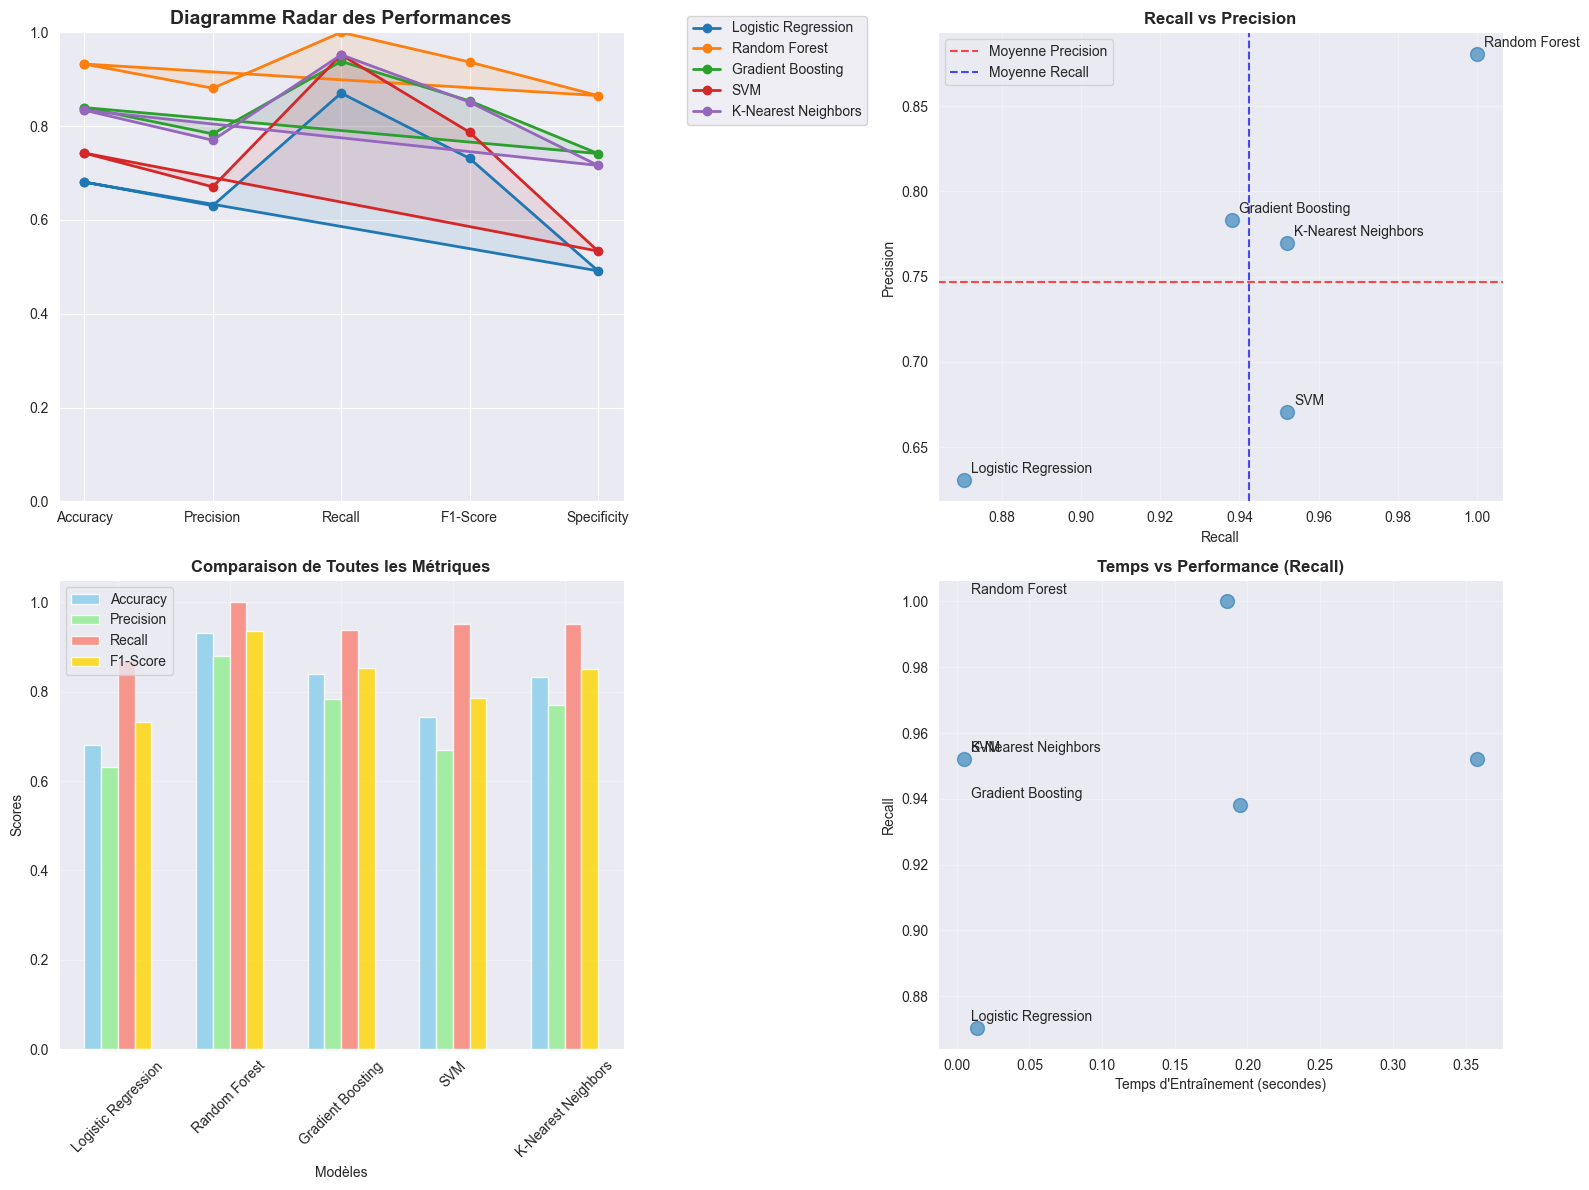


SÉLECTION DU MEILLEUR MODÈLE
MEILLEUR MODÈLE SÉLECTIONNÉ: Random Forest
Recall: 1.0000
Precision: 0.8809
Accuracy: 0.9325
F1-Score: 0.9367
emps d'entraînement: 0.19s


In [12]:
# Classement par Accuracy
accuracy_ranking = results_df.sort_values('Accuracy', ascending=False)
print("\nClassement par Accuracy:")
for i, (_, row) in enumerate(accuracy_ranking.iterrows(), 1):
    print(f"{i}. {row['Modèle']}: {row['Accuracy']:.4f}")

# Classement par Recall (le plus important pour la détection de fraude)
recall_ranking = results_df.sort_values('Recall', ascending=False)
print("\nClassement par Recall (MÉTRIQUE CLÉ):")
for i, (_, row) in enumerate(recall_ranking.iterrows(), 1):
    print(f"{i}. {row['Modèle']}: {row['Recall']:.4f}")

# Classement par F1-Score
f1_ranking = results_df.sort_values('F1-Score', ascending=False)
print("\nClassement par F1-Score:")
for i, (_, row) in enumerate(f1_ranking.iterrows(), 1):
    print(f"{i}. {row['Modèle']}: {row['F1-Score']:.4f}")

# Analyse détaillée des performances
print("\n" + "=" * 50)
print("ANALYSE DÉTAILLÉE DES PERFORMANCES")
print("=" * 50)

for _, row in results_df.iterrows():
    print(f"\n{row['Modèle']}:")
    print(f"• Capacité de détection (Recall): {row['Recall']:.1%} des fraudes détectées")
    print(f"• Précision des alertes: {row['Precision']:.1%} des alertes sont de vraies fraudes")
    print(f"• Exactitude globale: {row['Accuracy']:.1%} de prédictions correctes")
    print(f"• Faux négatifs: {row['FN']} fraudes non détectées (RISQUE)")
    print(f"• Faux positifs: {row['FP']} fausses alertes")

# Visualisation comparative avancée
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Radar chart des performances
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity']
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Fermer le cercle

ax = axes[0,0]
for i, row in results_df.iterrows():
    values = [row[metric] for metric in metrics]
    values += values[:1]  # Fermer le cercle
    ax.plot(angles, values, 'o-', linewidth=2, label=row['Modèle'])
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.set_title('Diagramme Radar des Performances', fontweight='bold', size=14)
ax.legend(bbox_to_anchor=(1.1, 1.05))

# Comparaison Recall vs Precision
axes[0,1].scatter(results_df['Recall'], results_df['Precision'], s=100, alpha=0.6)
for i, row in results_df.iterrows():
    axes[0,1].annotate(row['Modèle'], (row['Recall'], row['Precision']),
                      xytext=(5, 5), textcoords='offset points')
axes[0,1].axhline(y=results_df['Precision'].mean(), color='red', linestyle='--', alpha=0.7, label='Moyenne Precision')
axes[0,1].axvline(x=results_df['Recall'].mean(), color='blue', linestyle='--', alpha=0.7, label='Moyenne Recall')
axes[0,1].set_xlabel('Recall')
axes[0,1].set_ylabel('Precision')
axes[0,1].set_title('Recall vs Precision', fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Barres groupées pour toutes les métriques
x = np.arange(len(results_df))
width = 0.15
metrics_comparison = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightgreen', 'salmon', 'gold']

for i, metric in enumerate(metrics_comparison):
    axes[1,0].bar(x + i*width, results_df[metric], width, label=metric, color=colors[i], alpha=0.8)

axes[1,0].set_xlabel('Modèles')
axes[1,0].set_ylabel('Scores')
axes[1,0].set_title('Comparaison de Toutes les Métriques', fontweight='bold')
axes[1,0].set_xticks(x + width*1.5)
axes[1,0].set_xticklabels(results_df['Modèle'], rotation=45)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Temps d'entraînement vs Performance
training_times_list = [training_times[name] for name in results_df['Modèle']]
axes[1,1].scatter(training_times_list, results_df['Recall'], s=100, alpha=0.6)
for i, row in results_df.iterrows():
    axes[1,1].annotate(row['Modèle'], (training_times[name], row['Recall']),
                      xytext=(5, 5), textcoords='offset points')
axes[1,1].set_xlabel('Temps d\'Entraînement (secondes)')
axes[1,1].set_ylabel('Recall')
axes[1,1].set_title('Temps vs Performance (Recall)', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Sélection du meilleur modèle
print("\n" + "=" * 50)
print("SÉLECTION DU MEILLEUR MODÈLE")
print("=" * 50)

# Pour la détection de fraude, le Recall est la métrique la plus importante
best_model_name = results_df.loc[results_df['Recall'].idxmax(), 'Modèle']
best_model = trained_models[best_model_name]
best_model_metrics = results_df[results_df['Modèle'] == best_model_name].iloc[0]

print(f"MEILLEUR MODÈLE SÉLECTIONNÉ: {best_model_name}")
print(f"Recall: {best_model_metrics['Recall']:.4f}")
print(f"Precision: {best_model_metrics['Precision']:.4f}")
print(f"Accuracy: {best_model_metrics['Accuracy']:.4f}")
print(f"F1-Score: {best_model_metrics['F1-Score']:.4f}")
print(f"emps d'entraînement: {training_times[best_model_name]:.2f}s")

In [13]:
#SAUVEGARDE DU MEILLEUR MODÈLE
import os
import json
from datetime import datetime

# Création du dossier models s'il n'existe pas
if not os.path.exists('models'):
    os.makedirs('models')

# Sauvegarde du modèle
model_filename = f'models/best_fraud_detection_model_{datetime.now().strftime("%Y%m%d_%H%M")}.pkl'
joblib.dump(best_model, model_filename)
print(f"Modèle sauvegardé: {model_filename}")

# Sauvegarde du scaler
scaler_filename = 'models/scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f"Scaler sauvegardé: {scaler_filename}")

# Sauvegarde des métriques du modèle
model_metrics = {
    'model_name': best_model_name,
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'performance_metrics': {
        'accuracy': float(best_model_metrics['Accuracy']),
        'precision': float(best_model_metrics['Precision']),
        'recall': float(best_model_metrics['Recall']),
        'f1_score': float(best_model_metrics['F1-Score']),
        'specificity': float(best_model_metrics['Specificity'])
    },
    'dataset_info': {
        'training_samples': X_train.shape[0],
        'test_samples': X_test.shape[0],
        'features': X_train.shape[1],
        'classes_distribution': {
            'class_0': int(np.sum(y_train == 0)),
            'class_1': int(np.sum(y_train == 1))
        }
    }
}

metrics_filename = 'models/model_metrics.json'
with open(metrics_filename, 'w') as f:
    json.dump(model_metrics, f, indent=2)
print(f"Métriques sauvegardées: {metrics_filename}")

# Sauvegarde de tous les résultats pour référence
all_results_filename = 'models/all_models_comparison.csv'
results_df.to_csv(all_results_filename, index=False)
print(f"Comparaison complète sauvegardée: {all_results_filename}")

# Vérification de la sauvegarde
print("\nVÉRIFICATION DES FICHIERS SAUVEGARDÉS:")
saved_files = [
    model_filename,
    scaler_filename,
    metrics_filename,
    all_results_filename
]

for file in saved_files:
    if os.path.exists(file):
        file_size = os.path.getsize(file) / 1024  # Taille en KB
        print(f"{file} ({file_size:.1f} KB)")
    else:
        print(f"{file} - FICHIER NON TROUVÉ")

print(f"\nSAUVEGARDE TERMINÉE AVEC SUCCÈS!")
print(f"   Modèle: {best_model_name}")
print(f"   Recall: {best_model_metrics['Recall']:.1%}")

Modèle sauvegardé: models/best_fraud_detection_model_20251031_2007.pkl
Scaler sauvegardé: models/scaler.pkl
Métriques sauvegardées: models/model_metrics.json
Comparaison complète sauvegardée: models/all_models_comparison.csv

VÉRIFICATION DES FICHIERS SAUVEGARDÉS:
models/best_fraud_detection_model_20251031_2007.pkl (3211.2 KB)
models/scaler.pkl (1.3 KB)
models/model_metrics.json (0.5 KB)
models/all_models_comparison.csv (0.8 KB)

SAUVEGARDE TERMINÉE AVEC SUCCÈS!
   Modèle: Random Forest
   Recall: 100.0%
